In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})

In [2]:
url = 'https://raw.githubusercontent.com/dtrihinas/covid-19-cyprus-data/master/coronavirus_cyprus_data.csv'
data = pd.read_csv(url, index_col='caseid')
data.head()

,date,gender,age,nationality,area,impact,profession,hospitalized,ICU,recovered,relation
caseid,,,,,,,,,,,
1,10/03/2020,M,25.0,cypriot,nicosia,travel (italy),NaN,0,0,1,-1
2,10/03/2020,M,64.0,cypriot,nicosia,travel (uk),doctor,0,0,0,-1
3,11/03/2020,M,NaN,cypriot,nicosia,travel (uk),NaN,1,0,0,-1
4,11/03/2020,F,NaN,cypriot,nicosia,travel (uk),NaN,1,0,0,-1
5,11/03/2020,NaN,NaN,cypriot,limassol,travel (italy),NaN,1,0,0,-1


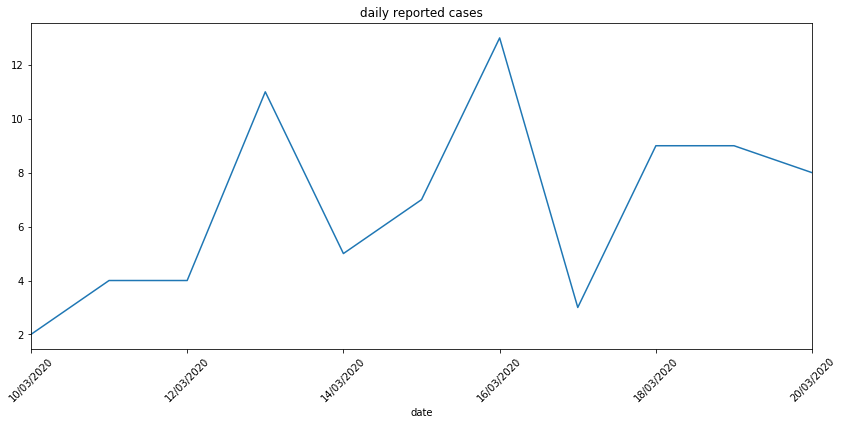

In [3]:
cum_cases = data.groupby('date').size()
cum_cases.plot(figsize=(14,6), title='daily reported cases', rot=45)

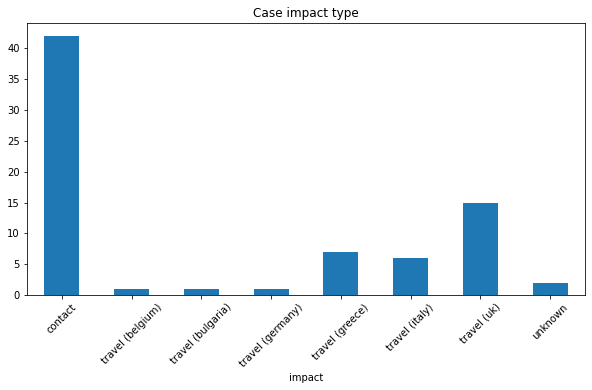

In [4]:
case_impact = data.groupby('impact').size()
case_impact.plot(kind='bar',x='impact',y='cases', title='Case impact type', rot=45, figsize=(10,5))

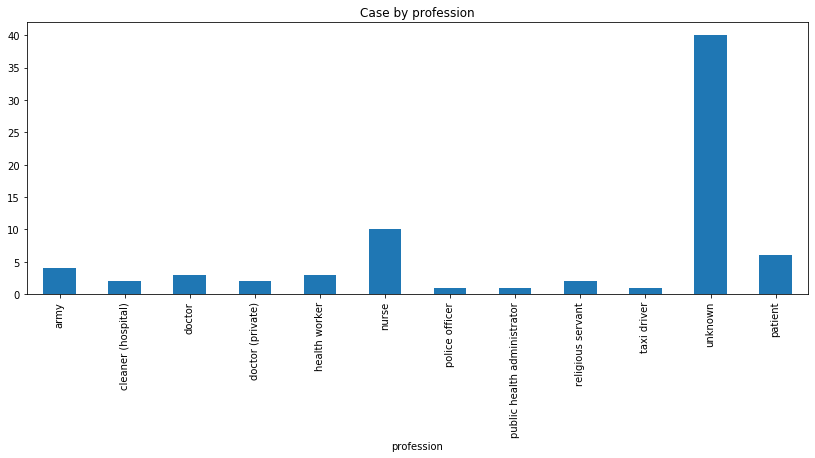

In [6]:
case_profession = data.groupby('profession').size()
unknown_prof = data.index.size - case_profession.sum()
case_profession['unknown'] = unknown_prof
patients = ~case_profession.index.str.extract(r'(^patient)').isna()[0].values #bool array matching patients
total_patient_count = case_profession[patients].sum() #merge patient count from different hospitals
case_profession[patients == True] = np.nan
case_profession = case_profession.dropna()
case_profession['patient'] = total_patient_count
case_profession.plot(kind='bar',x='profession',y='cases', title='Case by profession', rot=90, figsize=(14,5))